# 自回归条件异方差ARCH模型

## 1. ARCH的理论
对于金融时间序列，波动率往往具有以下特征：
- 存在波动率聚集现象，即波动率在一段时间上高，一段时间上低。
- 波动率以连续时间变化，很少发生跳跃。
- 波动率不会发散到无穷，波动率往往是平稳的。
- 波动率对价格大幅上升和大幅下降的反应是不同的。

ARCH模型：
1. 资产收益率序列的扰动${a_t}$是序列不相关的，但是不独立。
2. ${a_t}$的不独立性可以用其延迟值的简单二次函数来描述。

模型形式如下：
$$
r_t = \mu + a_t
$$
$$
a_t = \sigma_t \epsilon_t
$$
$$
\sigma^2 = \beta_0 + \beta_1 \sigma^2_{t-1} + \dots + \beta_m \sigma^2_{t-m}>0
$$
其中，$\epsilon_t$为均值为0，方差为1的独立同分布（i.i.d.）的随机变量序列。

## 2. ARCH模型的建立

ARCH模型的建立大致分成以下几步：
1. 均值方程的建立
2. 对均值方程的残差进行ARCH效应检验
3. 如果具有ARCH效应，则建立波动率模型
4. 检验拟合的模型，如有必要则进行改进

### 2.1 均值方程的建立

首先检验平稳性，是否需要差分。

原假设$H_0$:序列为非平稳的；
备择假设$H_1$:序列是平稳的。


In [1]:
import pandas as pd
data = pd.read_csv("datasets/收益率时间序列.csv")
data.head()

,close,daily_return
0,3595.18,-0.010228
1,3586.08,-0.002531
2,3579.54,-0.001824
3,3593.52,0.003906
4,3567.44,-0.007258


In [2]:
import statsmodels.api as sm
res = sm.tsa.stattools.adfuller(data['daily_return'])
print('p-value', res[1])

p-value 3.755419403177572e-22


In [2]:
import numpy as np
np.__version__

'1.21.5'

p值小于显著性水平，拒绝原假设，因此序列是平稳的，接下来建立AR(p)模型，先判定阶次：

/Users/hans/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


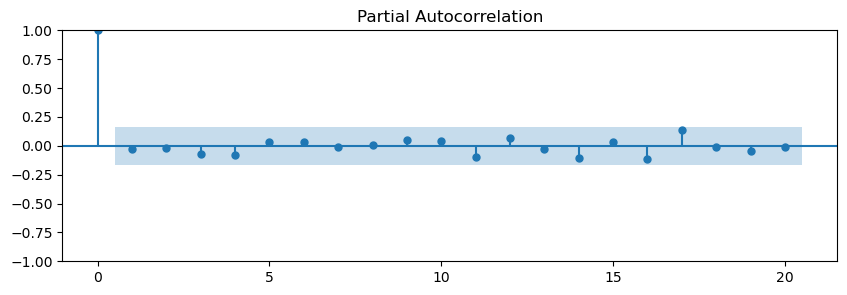

In [3]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,3))
ax1 = fig.add_subplot(111)
fig = sm.graphics.tsa.plot_pacf(data['daily_return'], lags=20, ax=ax1)
plt.show()

如何看图可参考：https://blog.csdn.net/weixin_49583390/article/details/121914303

关于绘制acf和pacf的命令，参照[链接](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)。

如果需要进一步学习acf和pacf的知识，参考：Brockwell and Davis, 1987. Time Series Theory and Methods [2] Brockwell and Davis, 2010. Introduction to Time Series and Forecasting, 2nd edition.

于是我们建立AR(8)模型，即均值方程：

In [4]:
ts = pd.Series(data['daily_return'])

In [5]:
order=(8, 0, 0)
model = sm.tsa.ARIMA(ts, order=order).fit()

### 2.2 ARCH效应的检验

利用前面的金融时间序列中的混成检验（Ljung-Box），检验序列${a_t^2}$的相关性，来判断是否具有ARCH效应。

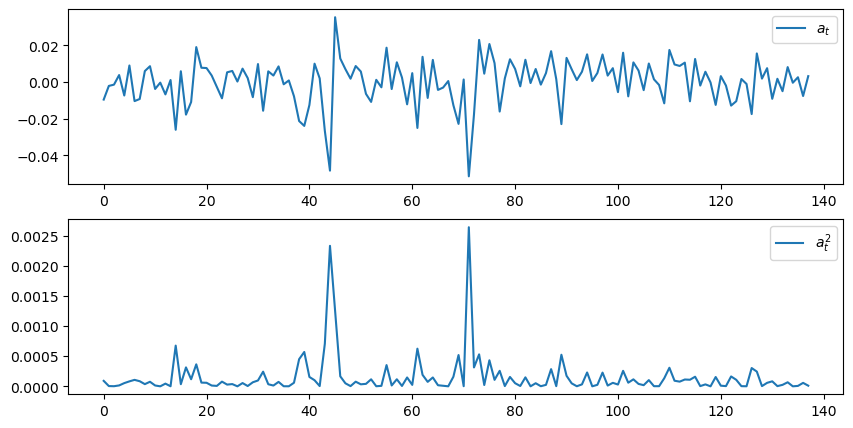

In [8]:
a_t = data['daily_return'] - model.fittedvalues
import numpy as np
a_t_2 = np.square(a_t)
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(a_t, label='$a_t$')
plt.legend(loc=1)
plt.subplot(212)
plt.plot(a_t_2, label='$a_t^2$')
plt.legend(loc=1)
plt.show()

然后对${a_t^2}$进行混成检验。

原假设$H_0$:序列没有相关性；备择假设$H_1$：序列具有相关性。

In [ ]:
m = 25
acf, q, p = sm.tsa.acf(a_t_2, nlags=m, qstat=True)
out = np.c_[range(1, 26), acf[1:], q, p]
output = pd.DataFrame(out, columns=['lag', "AC", 'Q', 'P-value'])
output = output.set_index('lag')

In [ ]:
output

p-value小于显著性水平5%， 我们拒绝原假设，即认为序列具有相关性。因此具有ARCH效应。

### 2.3 ARCH模型的建立

首先确定ARCH模型的阶次，可以用${a_t^2}$序列的偏自相关函数PACF来确定：

In [ ]:
fig = plt.figure(figsize=(10,3))
ax1 = fig.add_subplot(111)
fig = sm.graphics.tsa.plot_pacf(a_t_2, lags=30, ax=ax1)
plt.show()

按照我们之前的分析，粗略选择均值模型AR(8)模型，波动率模型选择ARCH(4)模型。

In [ ]:
train = data['rate'][:-10]
test = data['rate'][-10:]

Python arch库

文档：https://bashtage.github.io/arch/index.html

In [ ]:
import arch
am = arch.arch_model(train, mean='AR', lags=8, vol='ARCH', p=4)
res = am.fit()

In [ ]:
print(res.summary())

可以看到我们的模型为：

$$
r_t = 0.001534 + 0.095342 a_1 + \dots + 0.021125 a_{t-8} 
$$
$$
\sigma^2 = 0.000123 + 0.156412 \sigma^2_{t-1} + \dots + 0.156412 \sigma^2_{t-4}
$$